# [DRAFT] Combining New Fmask with S2 ARD and Applying WOfS <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Prerequisits** Users of this notebook should complete
    * [DEA Water Observations](DEA_Water_Observations.ipynb) for context of WOfS
    * [Applying WOfS to S2](Applying_WOfS_to_S2.ipynb) to see how WOfS can be applied to Sentinel 2 ARD 

## Background
Upon investigation, some errors from the fmask layer have been propagated through to the Water Observations (Sentinel 2, Provisional) output. Some new fmask layers have been generated using different parameters `Fmask_Outputs`. We cannot conclude they are improvements until the layers have been sent through WOfS to evaluate the final output.

To send the new Fmask layers through WOfS, we can combine them with the S2 ARD bands required for WOfS. In this notebook, we will load an Fmask geotiff and combine it with a S2 ARD granule as an `xarray.Dataset` for further analysis. 

# i didn't actually use this but don't know if it would be a good resource: 
For advice on exporting raster data, refer to the [Exporting GeoTIFFs](../How_to_guides/Exporting_GeoTIFFs.ipynb) notebook.

For more information on the `xarray` and `rioxarray` functions used:

* `rioxarray.open_rasterio` (https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio)
* `xarray.open_dataset` (http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)
* `xarray.open_mfdataset` (http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html)

## Description
This notebook shows how to open raster data from file using `xarray`'s built-in fuctions for handling GeoTIFF and NetCDF files, and merging the raster data with S2 ARD.

1. Opening single GEOTIFF raster files (the new fmask output)
    * convert to xarray
2. Find corresponding S2 ARD from datacube.
    * convert to xarray
3. Combine the two arrays to get one full dataset. 
    * ensure they have the same spatial reference
4. Apply WOfS and evaluate the output
***

## Getting started
 To run this example, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import numpy as np
import glob
import xarray as xr
import rioxarray
import datacube
import rasterio.crs
import rasterio
# from rasterio.crs import CRS as CoordRS
from datetime import datetime, timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry, CRS
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.masking import mask_invalid_data
from odc.ui import with_ui_cbk
from odc.algo import xr_reproject
# from wofs.wofls import woffles_ard


import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import paths_to_datetimeindex, load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb, plot_wo
from dea_tools.temporal import time_buffer
from dea_tools.spatial import xr_rasterize
from dea_tools.dask import create_local_dask_cluster

# local copies
sys.path.insert(1, "../Applying WOfS to S2/wofs-1.6.5/")
from wofs.wofls import woffles_ard

## Opening a single raster file


### Define file paths
In the code below we define the locations of the GeoTIFF files that we will open. These were created when testing fmask parameters on S2 imagery. The fmask output is a classified layer with 5 classes.

In [2]:
sys.path.insert(1, '../dev/dea-notebooks/')
geotiff_path = '../S2_WO_Quality_Testing/Fmask_Outputs/testparallax_wgs84_0.tif'

### Open the new Fmask layer

To open a geotiff we use `rioxarray.open_rasterio()` function which is built around the `rasterio` Python package.
When dealing with extremely large rasters, this function can be used to load data as a Dask array by providing a `chunks` parameter (e.g. `chunks={'x': 1000, 'y': 1000}`). This can be useful to reduce memory usage by only loading the specific portion of the raster you are interested in.

In [3]:
# Open into an xarray.DataArray
geotiff_da = rioxarray.open_rasterio(geotiff_path)
geotiff_da = geotiff_da.rio.write_nodata(0, encoded = True, inplace = True)
# Covert our xarray.DataArray into a xarray.Dataset
geotiff_dss = geotiff_da.to_dataset('band')

# Rename the variable to a more useful name
geotiff_ds = geotiff_dss.rename({1: 'fmask'})

# check array
print(geotiff_ds, '\n', geotiff_ds.spatial_ref)
geotiff_ds

<xarray.Dataset>
Dimensions:      (y: 6094, x: 6096)
Coordinates:
  * x            (x) float64 1.925e+05 1.925e+05 ... 3.144e+05 3.144e+05
  * y            (y) float64 6.206e+06 6.206e+06 ... 6.084e+06 6.084e+06
    spatial_ref  int64 0
Data variables:
    fmask        (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:       Area
    DataType:            Thematic
    RepresentationType:  THEMATIC
    scale_factor:        1.0
    add_offset:          0.0 
 <xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes: (12/18)
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 54S",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    ...                                ...
    longitude_of_central_meridian:     141.0
    false_easting:     

<xarray.Dataset>
Dimensions:      (y: 6094, x: 6096)
Coordinates:
  * x            (x) float64 1.925e+05 1.925e+05 ... 3.144e+05 3.144e+05
  * y            (y) float64 6.206e+06 6.206e+06 ... 6.084e+06 6.084e+06
    spatial_ref  int64 0
Data variables:
    fmask        (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:       Area
    DataType:            Thematic
    RepresentationType:  THEMATIC
    scale_factor:        1.0
    add_offset:          0.0

## ~Clip Fmask to Area of Interest~
Clipping the layer to a smaller area can help speed things up for testing purposes. When applying this method to a S2 granule, the granule boundary can be used instead. <b> Warning: This will require more processing power and the kernel may crash if you don't have enough </b> The study area here is a section of Adelaide.

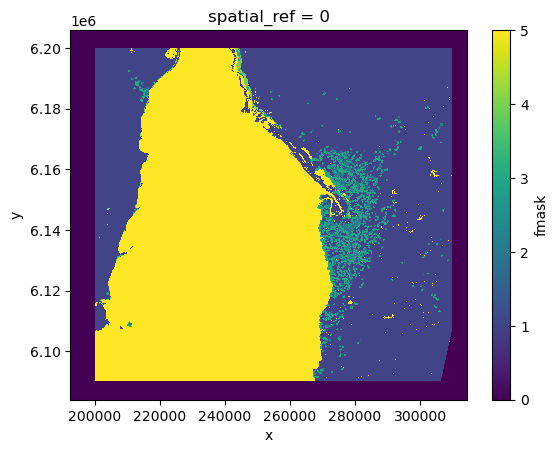

In [5]:
geotiff_ds.fmask.plot()

We can plot the data to verify it loaded correctly:

In [6]:
geotiff_ds.info
geotiff_ds['fmask'].attrs = {'nodata': 0,
                             'bits': [0, 1, 2, 3, 4, 5, 6, 7], 
                             'values': {'0': 'nodata', '1': 'valid', '2': 'cloud', '3': 'shadow', '4': 'snow', '5': 'water'}, 
                             'description': 'Fmask'}

In [7]:
geotiff_ds

<xarray.Dataset>
Dimensions:      (y: 6094, x: 6096)
Coordinates:
  * x            (x) float64 1.925e+05 1.925e+05 ... 3.144e+05 3.144e+05
  * y            (y) float64 6.206e+06 6.206e+06 ... 6.084e+06 6.084e+06
    spatial_ref  int64 0
Data variables:
    fmask        (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:       Area
    DataType:            Thematic
    RepresentationType:  THEMATIC
    scale_factor:        1.0
    add_offset:          0.0

## Load Corresponding S2 ARD
This S2 ARD has the same date as the new Fmask layer. When loading in the ARD, the S2 `fmask` will not be needed. Bands required in this notebook are `nbart_coastal_aerosol`, `nbart_blue`, `nbart_green`, `nbart_red`, `nbart_nir_1`, `nbart_nir_2`, `nbart_swir_2`, and `nbart_swir_3`. To save time, we can clip this layer to the same study area as the Fmask layer.

When loading in data, it is convenient to separate fixed parameters that will not need updating from the dynamic variables that can be changed for testing, and .

In [8]:
dc = datacube.Datacube(app='Cloud_Masking_fromfmask')
# client = create_local_dask_cluster(return_client=True)

In [9]:
# Fixed parameters
products = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]
# don't need red edge, not concerned about vegetation.
measurements1 = ["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3", "oa_fmask"]
measurements = ["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"]
resolution = (-10, 10) #testing -20,20, original -10,10 (12/12/23)
output_crs = "EPSG:3577"
align = (5, 5) # check this
maturity = "final" 


In [10]:
# Dynamic Parameters
time_of_interest = '2023-04-24' #for testing purposes - only working with single timesteps
time_buff = '1 days' #optional, if known date for image

In [11]:
# Find matching datasets    
def loadquery(products, time_of_interest, time_buff, measurements1, resolution, align):
    # Extract the feature's geometry as a datacube geometry object
    # geom = Geometry(geom=row.geometry, crs=gdf.crs)
         
    # dss = dc.find_datasets(product=products, time=time_of_interest, geopolygon=geom)
    # Identify native CRS from datasets; fall back on "EPSG:3577"    # if no data is found to prevent an error    
    # native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    query = {'time': time_buffer(time_of_interest, buffer=time_buff),
             'measurements': measurements1,
            # 'resolution': resolution,
            # 'output_crs': native_crs,
            # 'align': align,
             'like': geotiff_dss.geobox,
             'group_by': 'solar_day'#,
             #'dask_chunks':{}
             }

    # Update the query to include our geopolygon
    # query.update({'geopolygon': geom})                                            
                                              
    return query                                         


In [12]:
 
query = loadquery(products, time_of_interest, time_buff, measurements1, resolution, align)

# Load Sentinel 2
ds1 = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
        progress_cbk=with_ui_cbk(),
        dataset_maturity="final",
        **query)
ds1['fmask'] = ds1['oa_fmask']

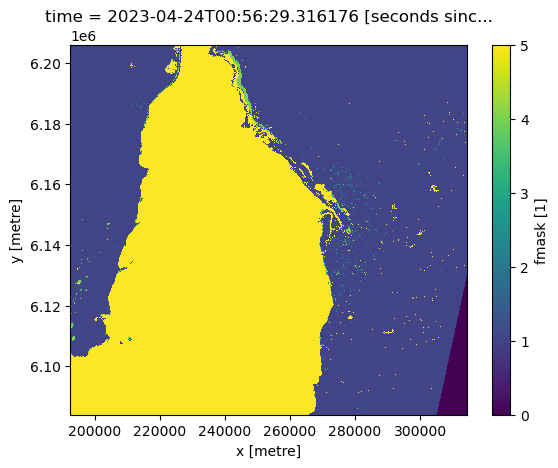

In [13]:
ds1.fmask.plot()

In [14]:
ds1.isel(time=0)

<xarray.Dataset>
Dimensions:                (y: 6094, x: 6096)
Coordinates:
    time                   datetime64[ns] 2023-04-24T00:56:29.316176
  * y                      (y) float64 6.206e+06 6.206e+06 ... 6.084e+06
  * x                      (x) float64 1.925e+05 1.925e+05 ... 3.144e+05
    spatial_ref            int32 32754
Data variables:
    nbart_coastal_aerosol  (y, x) int16 630 630 632 632 ... -999 -999 -999 -999
    nbart_blue             (y, x) int16 881 890 838 891 ... -999 -999 -999 -999
    nbart_green            (y, x) int16 1150 1157 1109 1145 ... -999 -999 -999
    nbart_red              (y, x) int16 1647 1670 1561 1614 ... -999 -999 -999
    nbart_nir_1            (y, x) int16 2282 2309 2193 2232 ... -999 -999 -999
    nbart_nir_2            (y, x) int16 2416 2420 2380 2357 ... -999 -999 -999
    nbart_swir_2           (y, x) int16 4224 4222 4119 4090 ... -999 -999 -999
    nbart_swir_3           (y, x) int16 2940 2905 2872 2832 ... -999 -999 -999
    oa_fmask               (y, x) uint8 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0
    fmask                  (y, x) uint8 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 54S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

/home/jovyan/dev/dea-notebooks/S2_WO_Quality_Testing/../Applying WOfS to S2/wofs-1.6.5/wofs/classifier.py:81: RuntimeWarning: divide by zero encountered in divide
  c = (a - b) / (a + b)


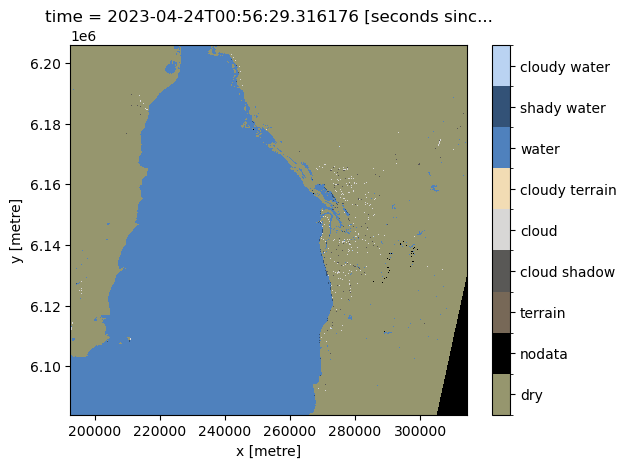

In [15]:
##testing - is woffles not working because of the new fmask? This uses the default fmask that is part of the s2 ard.
wofls = woffles_ard(ds1.isel(time=0), dsm=None)
plot_wo(wofls)

If using a study area that is not the small section of Adelaide `ID = 'ADE'`, update the key to the corresponding ID. 

In [16]:
# load ARD without fmask, merge the new fmask into the array
# Find matching datasets    
def loadquery(products, time_of_interest, time_buff, measurements, resolution, align):
    # Extract the feature's geometry as a datacube geometry object
    # geom = Geometry(geom=row.geometry, crs=gdf.crs)
         
    # dss = dc.find_datasets(product=products, time=time_of_interest, geopolygon=geom)
    # Identify native CRS from datasets; fall back on "EPSG:3577"    # if no data is found to prevent an error    
    # native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    query = {'time': time_buffer(time_of_interest, buffer=time_buff),
             'measurements': measurements,
            # 'resolution': resolution,
            # 'output_crs': native_crs,
            # 'align': align,
             'like': geotiff_dss.geobox,
             'group_by': 'solar_day'#,
           #  'dask_chunks':{}
             }

    # Update the query to include our geopolygon
    # query.update({'geopolygon': geom})                                            
                                              
    return query             

In [17]:
query = loadquery(products, time_of_interest, time_buff, measurements, resolution, align)

# Load Sentinel 2
ds = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
        progress_cbk=with_ui_cbk(),
        dataset_maturity="final",
        **query)

In [18]:
ds

<xarray.Dataset>
Dimensions:                (time: 1, y: 6094, x: 6096)
Coordinates:
  * time                   (time) datetime64[ns] 2023-04-24T00:56:29.316176
  * y                      (y) float64 6.206e+06 6.206e+06 ... 6.084e+06
  * x                      (x) float64 1.925e+05 1.925e+05 ... 3.144e+05
    spatial_ref            int32 32754
Data variables:
    nbart_coastal_aerosol  (time, y, x) int16 630 630 632 632 ... -999 -999 -999
    nbart_blue             (time, y, x) int16 881 890 838 891 ... -999 -999 -999
    nbart_green            (time, y, x) int16 1150 1157 1109 ... -999 -999 -999
    nbart_red              (time, y, x) int16 1647 1670 1561 ... -999 -999 -999
    nbart_nir_1            (time, y, x) int16 2282 2309 2193 ... -999 -999 -999
    nbart_nir_2            (time, y, x) int16 2416 2420 2380 ... -999 -999 -999
    nbart_swir_2           (time, y, x) int16 4224 4222 4119 ... -999 -999 -999
    nbart_swir_3           (time, y, x) int16 2940 2905 2872 ... -999 -999 -999
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 54S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

## Combine into single xarray.Dataset
It is difficult to use geospatial data individually when analysing, so it can be useful to load multiple files into a single `xarray.Dataset`.
This also allows us to analyse data in a format that is directly compatible with data directly loaded from the Datacube.

<b> This current method is for testing 1 timestep at a time to reduce dimension complications. </b> 

To reduce the dataset to one timestep, you can:
* drop the time dimension entirely -> ard.drop("time")
* take the first timestep ds.isel(time=0)
* or set time dimension for fmask and make it equal to ARD time, so the arrays will only merge if the timesteps match.


In [19]:
# geotiff_ds.fmask.plot()

In [20]:
ard = ds.isel(time=0)
# geotiff_ds = geotiff_dss.where(geotiff_dss['fmask'] != 0.)
datasets=[ard,geotiff_ds]

In [ ]:
# plot to check whether the datasets have been successfully combined
# rgb(ard) # commented out because takes a while to load and im impatient

In [ ]:
# geotiff_ds

We now read these files using `xarray`. 
To ensure each raster is labelled correctly with its time, we can use the helper function `paths_to_datetimeindex()` from `dea_datahandling` to extract time information from the file paths we obtained above.
We then load and concatenate each dataset along the `time` dimension using `rioxarray.open_rasterio()`, convert the resulting `xarray.DataArray` to a `xarray.Dataset`, and give the variable a more useful name (`red`):


To verify the data was loaded correctly, we can plot it using `xarray`:

In [21]:
comb2 = xr.merge(datasets, join='outer', compat = 'override')
comb2

<xarray.Dataset>
Dimensions:                (y: 6094, x: 6096)
Coordinates:
    time                   datetime64[ns] 2023-04-24T00:56:29.316176
  * y                      (y) float64 6.206e+06 6.206e+06 ... 6.084e+06
  * x                      (x) float64 1.925e+05 1.925e+05 ... 3.144e+05
    spatial_ref            int32 32754
Data variables:
    nbart_coastal_aerosol  (y, x) int16 630 630 632 632 ... -999 -999 -999 -999
    nbart_blue             (y, x) int16 881 890 838 891 ... -999 -999 -999 -999
    nbart_green            (y, x) int16 1150 1157 1109 1145 ... -999 -999 -999
    nbart_red              (y, x) int16 1647 1670 1561 1614 ... -999 -999 -999
    nbart_nir_1            (y, x) int16 2282 2309 2193 2232 ... -999 -999 -999
    nbart_nir_2            (y, x) int16 2416 2420 2380 2357 ... -999 -999 -999
    nbart_swir_2           (y, x) int16 4224 4222 4119 4090 ... -999 -999 -999
    nbart_swir_3           (y, x) int16 2940 2905 2872 2832 ... -999 -999 -999
    fmask                  (y, x) uint8 ...
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 54S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

In [ ]:
# comb2.fmask.plot()

In [ ]:
# comb2.nbart_red.plot()

## Apply WOfS
compare the different fmask -> wofs outputs. give name fmask_default and fmask, then swap out the names when running wofs to call the one you want.
pixel comparison by doing raster maths subtraction. the values will be dependent on the bit classification, so create a new legend because the bit subtraction will work. write everything out and see what happens. 

In [22]:
wofl = woffles_ard(comb2, dsm=None)

/home/jovyan/dev/dea-notebooks/S2_WO_Quality_Testing/../Applying WOfS to S2/wofs-1.6.5/wofs/classifier.py:81: RuntimeWarning: divide by zero encountered in divide
  c = (a - b) / (a + b)


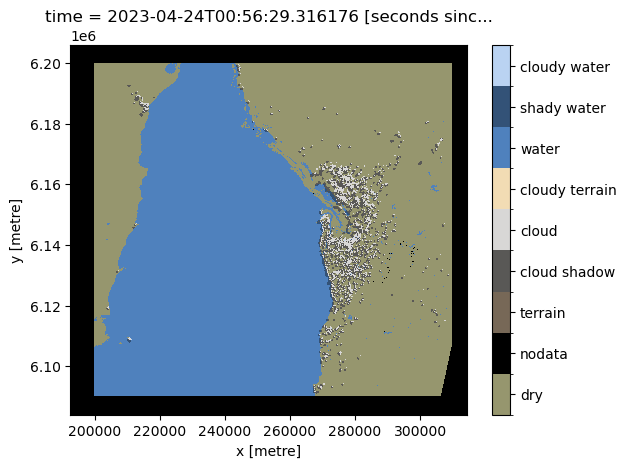

In [23]:
plot_wo(wofl)

In [ ]:
# plot original vs new, set up facet and make them side by side

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)